In [1]:
from _import_scripts import scripts
from scripts.notebook_utils import *
TIMELY_VARIABLES = {
    "ARRAY_WORDLINES": 256,
    "ARRAY_BITLINES": 256,
    "ARRAY_PARALLEL_WEIGHTS": 2,
    "ADC_RESOLUTION": 8,
    "DAC_RESOLUTION": 8,
    "N_ADC_PER_BANK": 32, 
    "SUPPORTED_INPUT_BITS": 8,
    "SUPPORTED_OUTPUT_BITS": 8,
    "SUPPORTED_WEIGHT_BITS": 8,
    "BITS_PER_CELL": 4,
    "CIM_UNIT_WIDTH_CELLS": 2,
}

display_markdown(
    """
# Basic Analog CiM Macro

Welcome to the CiMLoop Tutorials. This first tutorial will guide you through the
process of creating a basic analog CiM macro. Using this macro, we will explore
the CiMLoop syntax and important CiM components.

## Prerequisites

We assume that you have the following prerequisites: 

- An understanding of Timeloop and Accelergy. The Timeloop+Accelergy tutorial
  exercises are a prerequisite for this tutorial.
- An understanding of YAML syntax. CiMLoop uses YAML tags, anchors, and aliases
  to define the structure of the CiM macro.

## Introduction and Overview

The diagram below shows the structure of the analog CiM macro we will be
creating. In the diagram, we show a 3x3 weight matrix and a 3x3 array for
illustrative purposes, but in simulation we'll be using a 32x32 array.

![Analog CiM Macro](images/how_cim_works.svg)

This analog CiM macro stores a weight matrix and performs matrix-vector
operations using analog computation. For simplicity, in this tutorial we assume
that analog components are high-enough resolution to process all operands.

The macro consists of three main components:

- Memory Array: A 2D array of memory elements that store the weight matrix. Each
  of these memory elements, which we call a CiM unit, stores a weight and
  performs an analog multiply-accumulate (MAC) operation between its stored
  weight and an analog input value.
- Row Drivers + DAC: These are the circuits that provide analog input values to
  the memory array. The Digital Analog Converter (DACs) convert digital input
  values to analog voltages. The row drivers then apply these voltages to the
  rows of the memory array. *In this tutorial, we'll be using a simple
  pulse-train DAC that is folded into the row drivers. We'll therefore only be
  seeing a row driver in the macro definition.*
- Column Drivers + ADC: These are the circuits that read out the analog output
  values from the memory array. Column drivers select and read of CiM array
  columns, and Analog Digital Converters (ADCs) convert analog outputs from each
  column into digital values.

We'll dive into the details of each of these components later on, but for now,
we'll start by looking at the structure and syntax of how to define this macro
in CiMLoop.
"""
)


# Basic Analog CiM Macro

Welcome to the CiMLoop Tutorials. This first tutorial will guide you through the
process of creating a basic analog CiM macro. Using this macro, we will explore
the CiMLoop syntax and important CiM components.

## Prerequisites

We assume that you have the following prerequisites: 

- An understanding of Timeloop and Accelergy. The Timeloop+Accelergy tutorial
  exercises are a prerequisite for this tutorial.
- An understanding of YAML syntax. CiMLoop uses YAML tags, anchors, and aliases
  to define the structure of the CiM macro.

## Introduction and Overview

The diagram below shows the structure of the analog CiM macro we will be
creating. In the diagram, we show a 3x3 weight matrix and a 3x3 array for
illustrative purposes, but in simulation we'll be using a 32x32 array.

![Analog CiM Macro](images/how_cim_works.svg)

This analog CiM macro stores a weight matrix and performs matrix-vector
operations using analog computation. For simplicity, in this tutorial we assume
that analog components are high-enough resolution to process all operands.

The macro consists of three main components:

- Memory Array: A 2D array of memory elements that store the weight matrix. Each
  of these memory elements, which we call a CiM unit, stores a weight and
  performs an analog multiply-accumulate (MAC) operation between its stored
  weight and an analog input value.
- Row Drivers + DAC: These are the circuits that provide analog input values to
  the memory array. The Digital Analog Converter (DACs) convert digital input
  values to analog voltages. The row drivers then apply these voltages to the
  rows of the memory array. *In this tutorial, we'll be using a simple
  pulse-train DAC that is folded into the row drivers. We'll therefore only be
  seeing a row driver in the macro definition.*
- Column Drivers + ADC: These are the circuits that read out the analog output
  values from the memory array. Column drivers select and read of CiM array
  columns, and Analog Digital Converters (ADCs) convert analog outputs from each
  column into digital values.

We'll dive into the details of each of these components later on, but for now,
we'll start by looking at the structure and syntax of how to define this macro
in CiMLoop.



## Container-Hierarchy Representation

CiMLoop uses a container-hierarchy representation to define the structure of CiM
macros. A **container** is a grouping of components and/or (sub)containers, and
a **container-hierarchy** is a series of containers where each contains all
subsequent components/containers. Expressing the CiM macro as a hierarchy lets
us decompose the macro into smaller, easier-to-understand components. It also
lets the Timeloop mapper map to a wide variety of CiM macros.

Using a container-hierarchy representation, we can break down our CiM array into
three levels.

### The Macro Level 

At the top level, we have the macro. The macro contains the ADC, column drivers,
and row drivers (note that the DAC is included in the row drivers).

Below the macro, we break the CiM array into column containers, where each
container represents one column of CiM units. Row drivers supply input values
onto the rows; each row connects to all columns, so these input values are
*reused* between columns. Column drivers read outputs from each column, and an
ADC converts the analog outputs into digital values.

Our three-column CiM array has three column containers.



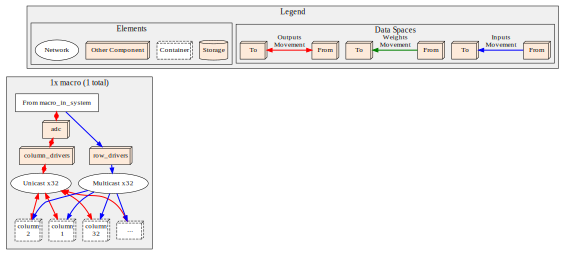


### The Column Level

Looking inside each column, we see that there is no additional hardware;
instead, the column is immediately broken down further into multiple rows. Each
row receives a different input value, and the analog outputs are reused (*i.e.*,
summed on a wire) between multiple rows.



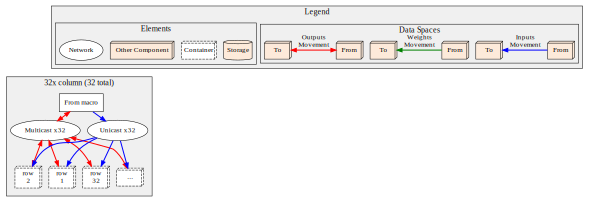


### The Row Level

Finally, looking inside each row, we see one `cim_unit` that stores a weight
value. In this macro, each `cim_unit` is capable of performing an analog
MAC operation between an 8b input and an 8b weight. To represent this
operation, we use 64x 1b MAC units, which act as a virtual representation of
the computation that occurs within the `cim_unit`.


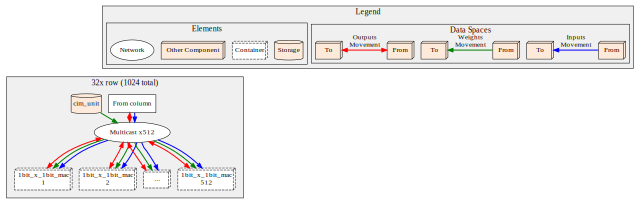

In [2]:
display_markdown(
    """
## Container-Hierarchy Representation

CiMLoop uses a container-hierarchy representation to define the structure of CiM
macros. A **container** is a grouping of components and/or (sub)containers, and
a **container-hierarchy** is a series of containers where each contains all
subsequent components/containers. Expressing the CiM macro as a hierarchy lets
us decompose the macro into smaller, easier-to-understand components. It also
lets the Timeloop mapper map to a wide variety of CiM macros.

Using a container-hierarchy representation, we can break down our CiM array into
three levels.

### The Macro Level 

At the top level, we have the macro. The macro contains the ADC, column drivers,
and row drivers (note that the DAC is included in the row drivers).

Below the macro, we break the CiM array into column containers, where each
container represents one column of CiM units. Row drivers supply input values
onto the rows; each row connects to all columns, so these input values are
*reused* between columns. Column drivers read outputs from each column, and an
ADC converts the analog outputs into digital values.

Our three-column CiM array has three column containers.

"""
)
display_diagram(get_diagram("basic_analog", ["macro"]))

display_markdown(
    """
### The Column Level

Looking inside each column, we see that there is no additional hardware;
instead, the column is immediately broken down further into multiple rows. Each
row receives a different input value, and the analog outputs are reused (*i.e.*,
summed on a wire) between multiple rows.

"""
)
display_diagram(get_diagram("basic_analog", ["column"]))

display_markdown(
    """
### The Row Level

Finally, looking inside each row, we see one `cim_unit` that stores a weight
value. In this macro, each `cim_unit` is capable of performing an analog
MAC operation between an 8b input and an 8b weight. To represent this
operation, we use 64x 1b MAC units, which act as a virtual representation of
the computation that occurs within the `cim_unit`.
"""
)
display_diagram(get_diagram("basic_analog", ["row"]))

In [3]:
ARCH_PATH = "../models/arch/1_macro/basic_analog/arch.yaml"


display_markdown(
    f"""
## CiMLoop Syntax

### Component Definitions

Components are identified with the !Component tag. Each component has a name,
which is unique in the system. Components also include:

- A `name`, which is unique in the system
- A `subclass`, or a reference to a component definition to calculate the area
  and the energy per action
- A set of `attributes`
- <Optional> For most components, we'll merge in sets of defaults, *e.g.,* `<<<:
  *[*component_defaults, *keep_inputs, *no_coalesce]`. These defaults, defined
  in a `defines.yaml` file, include various commonly-used attributes and
  constraints that we don't want cluttering our architecture specification.

There are more settings that are not listed above. The following tutorials will
explain those important for CiM, and a complete list can be [found in
documentation of the architecture
specification](https://timeloop.csail.mit.edu/v4).

#### Row Drivers


The row drivers are named `row_drivers`. They process inputs, but they're
analog components, so they can not temporally reuse or coalesce data as can a
buffer or larger storage element. For this reason, we'll include the
`[*component_defaults, *keep_inputs, *no_coalesce]` defaults.

Finally, we set the `attributes` of the `row_drivers`. The `width` attribute
tells how many bits are processed with each read/write; for the row drivers
and DAC, the DAC will have a fixed resolution and process that many bits at a
time. We use the `DAC_RESOLUTION` variable to capture its resolution. Inside the
`attributes` key, we include another set of default `cim_component_attributes`,
which is a set of commonly-used attributes for CiM components.

{get_yaml_file_markdown(ARCH_PATH, 'row_drivers', include_lines_before=1)}

#### ADC and Column Drivers

The `adc` component includes many of the same attributes as the
`row_drivers`. The `adc` processes outputs without reuse or
coalescing, so we merge in the `[*component_defaults, *keep_outptus, *no_coalesce]`
definition. We have a `adc` subclass defined elsewhere with the
`adc` components.

In the `adc` `attributes`, we again include the common set of CiM
attributes. We set the width to `ENCODED_OUTPUT_BITS`. This is different than
the DAC width setting. The difference is explained in the following:

- We set the DAC width to `DAC_RESOLUTION` because, in each cycle, the DAC may
  process DAC_RESOLUTION input bits.
- We set the ADC width to `ENCODED_OUTPUT_BITS` because, regardless of the ADC
  resolution, *any* update to an output bit may affect *all* output bits. For
  example, if we add `b1` to `b11111111`, then all eight bits of the latter will
  be affected. For this reason, *all* output-processing components process all
  bits of each output.
  
{get_yaml_file_markdown(ARCH_PATH, 'adc', include_lines_before=1)}
  
The column drivers behave the same as the ADC; they read outputs from the
columns and process them without reuse or coalescing. We'll use the same attributes
as the ADC.

{get_yaml_file_markdown(ARCH_PATH, 'column_drivers', include_lines_before=1)}
  
"""
)


## CiMLoop Syntax

### Component Definitions

Components are identified with the !Component tag. Each component has a name,
which is unique in the system. Components also include:

- A `name`, which is unique in the system
- A `subclass`, or a reference to a component definition to calculate the area
  and the energy per action
- A set of `attributes`
- <Optional> For most components, we'll merge in sets of defaults, *e.g.,* `<<<:
  *[*component_defaults, *keep_inputs, *no_coalesce]`. These defaults, defined
  in a `defines.yaml` file, include various commonly-used attributes and
  constraints that we don't want cluttering our architecture specification.

There are more settings that are not listed above. The following tutorials will
explain those important for CiM, and a complete list can be [found in
documentation of the architecture
specification](https://timeloop.csail.mit.edu/v4).

#### Row Drivers


The row drivers are named `row_drivers`. They process inputs, but they're
analog components, so they can not temporally reuse or coalesce data as can a
buffer or larger storage element. For this reason, we'll include the
`[*component_defaults, *keep_inputs, *no_coalesce]` defaults.

Finally, we set the `attributes` of the `row_drivers`. The `width` attribute
tells how many bits are processed with each read/write; for the row drivers
and DAC, the DAC will have a fixed resolution and process that many bits at a
time. We use the `DAC_RESOLUTION` variable to capture its resolution. Inside the
`attributes` key, we include another set of default `cim_component_attributes`,
which is a set of commonly-used attributes for CiM components.

```yaml
!Component # Row drivers feed inputs onto the rows of the array
name: row_drivers
<<<: [*component_defaults, *keep_inputs, *no_coalesce]
subclass: input_row_drivers
attributes: {width: DAC_RESOLUTION, <<: *cim_component_attributes, temporal_spiking: true}
```

#### ADC and Column Drivers

The `adc` component includes many of the same attributes as the
`row_drivers`. The `adc` processes outputs without reuse or
coalescing, so we merge in the `[*component_defaults, *keep_outptus, *no_coalesce]`
definition. We have a `adc` subclass defined elsewhere with the
`adc` components.

In the `adc` `attributes`, we again include the common set of CiM
attributes. We set the width to `ENCODED_OUTPUT_BITS`. This is different than
the DAC width setting. The difference is explained in the following:

- We set the DAC width to `DAC_RESOLUTION` because, in each cycle, the DAC may
  process DAC_RESOLUTION input bits.
- We set the ADC width to `ENCODED_OUTPUT_BITS` because, regardless of the ADC
  resolution, *any* update to an output bit may affect *all* output bits. For
  example, if we add `b1` to `b11111111`, then all eight bits of the latter will
  be affected. For this reason, *all* output-processing components process all
  bits of each output.
  
```yaml
!Component # Column readout (ADC)
name: adc
<<<: [*component_defaults, *keep_outputs, *no_coalesce]
subclass: adc
attributes: {width: ENCODED_OUTPUT_BITS, <<<: *cim_component_attributes}
```
  
The column drivers behave the same as the ADC; they read outputs from the
columns and process them without reuse or coalescing. We'll use the same attributes
as the ADC.

```yaml
!Component # Column readout (ADC)
name: column_drivers
<<<: [*component_defaults, *keep_outputs, *no_coalesce]
subclass: column_drivers
attributes: {width: ENCODED_OUTPUT_BITS, <<<: *cim_component_attributes}
```
  


In [5]:
ARCH_PATH = "../models/arch/1_macro/basic_analog/arch.yaml"

display_markdown(
    f"""
### Container Definitions

Containers are identified with the !Container or !ArrayContainer tags. The
!ArrayContainer tag is a special type of container that represents a container
that is subdivides a CiM array. Containers share many of the same attributes as
components:


- A `name`, which is unique in the system
- A set of `attributes`.
- <Optional> A set of defaults, *e.g.,* `<<<: [*container_defaults]`. Like
  component defaults, container defaults include various commonly-used
  attributes and constraints that we don't want cluttering our architecture
  specification.
- A `spatial` directive that describes how many copies of this container are in
  the X direction (`meshX`) and Y direction (`meshY`).
- A set of `constraints` that constrain the space of spatial mappings to be
  explored.
- A `max_utilization` key tells the tool how to construct a maximum-utilization
  workload for this container. This is used to measure peak energy efficiency
  and throughput.

There are more settings that are not listed above. The following tutorials will
explain those important for CiM, and a complete list can be [found
here](https://timeloop.csail.mit.edu/v4/input-formats/design/architecture).

#### Macro

The `macro` container doesn't do anything special in this system; it contains
the full macro, and can be included in larger systems. We include the
`container_defaults` defaults.

{get_yaml_file_markdown(ARCH_PATH, 'Container # Macro')}

#### Column

The `column` includes the `container_defaults` as well. There are three columns
in the X direction, so we set the `meshX: 3` attribute in the `spatial` key.

Using the `!ArrayContainer` keyword specifies that this container is part of the
CiM array. Inputs are reused between different columns (i.e., all columns share
the same set of inputs), so we include the `*spatial_must_reuse_inputs` defaults
in addition to the `container_defaults`. By default, nothing is reused, so
outputs and weights are not reused between columns. Finally, note the word
"must" in the `must_reuse` attribute. Columns are hard-wired together, so
sharing inputs is a requirement.

We also set the `max_utilization` attribute. This attribute is used to construct
a maximum-utilization workload for this macro so that we can measure peak energy
efficiency and throughput. Here, a spatial factors directive says that if we'd
like to maximize utilization, then set M (output channels) equal to the fanout
(number of columns) so each column has a different output channel to work on.

Finally, we have a spatial constraint `maximize_dims: [Y, M]`. This constraint
acts as a hint to the mapper to reduce the size of the mapspace, telling it to
first greedily map the Y (weight bits) and M (output channel) dimensions across
the different columns of the array. We set these because columns share inputs,
and in most computations, we need all inputs to see all weight bits and all
output channels, so this decision will yield good reuse in our CiM array.

{get_yaml_file_markdown(ARCH_PATH, 'column', include_lines_before=1)}

#### Row

The `row` includes the `container_defaults` as well. There are three rows in the
Y direction, so we set the `meshY: 3` attribute in the `spatial` key.

The row is also part of the CiM array, so we use the `!ArrayContainer` keyword.
Outputs are reused between rows, so we use the `*spatial_must_reuse_outputs`
defaults in addition to the `container_defaults` (note that other dataspaces
aren't reused by default.) We set the `max_utilization` spatial factors to give
a different C (input channel) to each row.

We also set a spatial constraint to the rows, with `maximize_dims: [C, R, S]`
telling it to map input channels, rows of the weight filter, and columns of the
weight filter across different rows of the array. We set these because rows
share outputs, and in general, all outputs will see all input channels and all
rows/columns of the weight filter, so this decision will yield good reuse in our
CiM array.

{get_yaml_file_markdown(ARCH_PATH, 'row', include_lines_before=1)}

"""
)


### Container Definitions

Containers are identified with the !Container or !ArrayContainer tags. The
!ArrayContainer tag is a special type of container that represents a container
that is subdivides a CiM array. Containers share many of the same attributes as
components:


- A `name`, which is unique in the system
- A set of `attributes`.
- <Optional> A set of defaults, *e.g.,* `<<<: [*container_defaults]`. Like
  component defaults, container defaults include various commonly-used
  attributes and constraints that we don't want cluttering our architecture
  specification.
- A `spatial` directive that describes how many copies of this container are in
  the X direction (`meshX`) and Y direction (`meshY`).
- A set of `constraints` that constrain the space of spatial mappings to be
  explored.
- A `max_utilization` key tells the tool how to construct a maximum-utilization
  workload for this container. This is used to measure peak energy efficiency
  and throughput.

There are more settings that are not listed above. The following tutorials will
explain those important for CiM, and a complete list can be [found
here](https://timeloop.csail.mit.edu/v4/input-formats/design/architecture).

#### Macro

The `macro` container doesn't do anything special in this system; it contains
the full macro, and can be included in larger systems. We include the
`container_defaults` defaults.

```yaml
- !Container # Macro top-level
  name: macro
  <<<: [*container_defaults]
```

#### Column

The `column` includes the `container_defaults` as well. There are three columns
in the X direction, so we set the `meshX: 3` attribute in the `spatial` key.

Using the `!ArrayContainer` keyword specifies that this container is part of the
CiM array. Inputs are reused between different columns (i.e., all columns share
the same set of inputs), so we include the `*spatial_must_reuse_inputs` defaults
in addition to the `container_defaults`. By default, nothing is reused, so
outputs and weights are not reused between columns. Finally, note the word
"must" in the `must_reuse` attribute. Columns are hard-wired together, so
sharing inputs is a requirement.

We also set the `max_utilization` attribute. This attribute is used to construct
a maximum-utilization workload for this macro so that we can measure peak energy
efficiency and throughput. Here, a spatial factors directive says that if we'd
like to maximize utilization, then set M (output channels) equal to the fanout
(number of columns) so each column has a different output channel to work on.

Finally, we have a spatial constraint `maximize_dims: [Y, M]`. This constraint
acts as a hint to the mapper to reduce the size of the mapspace, telling it to
first greedily map the Y (weight bits) and M (output channel) dimensions across
the different columns of the array. We set these because columns share inputs,
and in most computations, we need all inputs to see all weight bits and all
output channels, so this decision will yield good reuse in our CiM array.

```yaml
- !ArrayContainer # Each column stores a different weight slice. Columns share inputs.
  name: column
  <<<: [*container_defaults, *spatial_must_reuse_inputs]
  spatial: {meshX: 32}
  constraints: {spatial: {maximize_dims: [Y, M]}}
  max_utilization: {spatial: {factors: [('M=' + str(column.get_fanout()))]}}
```

#### Row

The `row` includes the `container_defaults` as well. There are three rows in the
Y direction, so we set the `meshY: 3` attribute in the `spatial` key.

The row is also part of the CiM array, so we use the `!ArrayContainer` keyword.
Outputs are reused between rows, so we use the `*spatial_must_reuse_outputs`
defaults in addition to the `container_defaults` (note that other dataspaces
aren't reused by default.) We set the `max_utilization` spatial factors to give
a different C (input channel) to each row.

We also set a spatial constraint to the rows, with `maximize_dims: [C, R, S]`
telling it to map input channels, rows of the weight filter, and columns of the
weight filter across different rows of the array. We set these because rows
share outputs, and in general, all outputs will see all input channels and all
rows/columns of the weight filter, so this decision will yield good reuse in our
CiM array.

```yaml
- !ArrayContainer # Each row receives a different input. Rows share outputs.
  name: row
  <<<: [*container_defaults, *spatial_must_reuse_outputs]
  spatial: {meshY: 32}
  constraints: {spatial: {maximize_dims: [C, R, S]}}
  max_utilization: {spatial: {factors: [('C=' + str(row.get_fanout()))]}}
```



In [6]:
display_markdown(
    f"""
### Full Architecture Definition

The full architecture is simply a list of each component and/or container in
order. The list is implicitly hierarchical, so each element is a parent of
subsequent elements, and each container contains all following elements.

At the bottom of the architecture, we have a `cim_unit` component and another
`virtualized_mac` hierarchy. The `cim_unit`, as described earlier, is a collection
of memory cells that perform a MAC, while the `virtualized_mac` is a virtualization
of many 1b by 1b MACs to assemble a N-bit by N-bit MAC. These will be
explored later on in greater detail.

{get_yaml_file_markdown(ARCH_PATH, 'architecture')}
"""
)


### Full Architecture Definition

The full architecture is simply a list of each component and/or container in
order. The list is implicitly hierarchical, so each element is a parent of
subsequent elements, and each container contains all following elements.

At the bottom of the architecture, we have a `cim_unit` component and another
`virtualized_mac` hierarchy. The `cim_unit`, as described earlier, is a collection
of memory cells that perform a MAC, while the `virtualized_mac` is a virtualization
of many 1b by 1b MACs to assemble a N-bit by N-bit MAC. These will be
explored later on in greater detail.

```yaml
architecture:
  nodes: &macro # TOP MACRO
  # ===========================================================================
  - !Container # Macro top-level
    name: macro
    <<<: [*container_defaults]

  - !Component # Column readout (ADC)
    name: adc
    <<<: [*component_defaults, *keep_outputs, *no_coalesce]
    subclass: adc
    attributes: {width: ENCODED_OUTPUT_BITS, <<<: *cim_component_attributes}
  - !Component # Column readout (ADC)
    name: column_drivers
    <<<: [*component_defaults, *keep_outputs, *no_coalesce]
    subclass: column_drivers
    attributes: {width: ENCODED_OUTPUT_BITS, <<<: *cim_component_attributes}

  {{ignoreme_placeholder | default('') | indent(2)}}

  - !Component # Row drivers feed inputs onto the rows of the array
    name: row_drivers
    <<<: [*component_defaults, *keep_inputs, *no_coalesce]
    subclass: input_row_drivers
    attributes: {width: DAC_RESOLUTION, <<: *cim_component_attributes, temporal_spiking: true}

  - !ArrayContainer # Each column stores a different weight slice. Columns share inputs.
    name: column
    <<<: [*container_defaults, *spatial_must_reuse_inputs]
    spatial: {meshX: 32}
    constraints: {spatial: {maximize_dims: [Y, M]}}
    max_utilization: {spatial: {factors: [('M=' + str(column.get_fanout()))]}}

  - !ArrayContainer # Each row receives a different input. Rows share outputs.
    name: row
    <<<: [*container_defaults, *spatial_must_reuse_outputs]
    spatial: {meshY: 32}
    constraints: {spatial: {maximize_dims: [C, R, S]}}
    max_utilization: {spatial: {factors: [('C=' + str(row.get_fanout()))]}}

  - !Component # CiM unit stores weights and computes MACs. Defined in include/defines.yaml.
    <<<: *cim_unit 

  - !Hierarchical           # Virtualize an XxYxZ-bit MAC as multiple MAC units.
    nodes: *virtualized_mac # Defined in include/defines.yaml.
```


In [44]:
display_markdown(
    """
## Running CiMLoop

### Basic Run

To run CiMLoop, we'll load in the spec using one of our pre-defined helper
functions get_spec. We set the `MAX_UTILIZATION` variable to `True` to generate
a workload that fully utilizes our CiM array. We'll also increase the number of
rows and columns in the array to a more realistic 16x16.

Finally, we run the Timeloop mapper and parse the output. We'll print the
energy, area number of MACs, throughput, and energy efficiency.
"""
)


def run_basic_analog_spec(array_rows: int, array_columns: int):
    # Load in the specification
    # spec = get_spec("basic_analog")
    spec = get_spec("timely")#, system="ws_dummy_buffer_many_macro")

    # Enable the MAX_UTILIZATION variable. This will generate a
    # workload that maximizes the utilization of the array.
    spec.variables["MAX_UTILIZATION"] = True
    spec.variables["NUM_CHIPS"] = 1

    # Set the number of rows and columns in the array
    spec.architecture.find("column").spatial.meshX = array_columns
    spec.architecture.find("row").spatial.meshY = array_rows

    return run_mapper(spec, True)


results = run_basic_analog_spec(array_rows=256, array_columns=256)
print(f"Total Energy (pJ): {results.energy*1e12:.2f}")
print(f"Total Area (um^2): {results.area*1e12:.2f}")
print(f"Number of MACs: {results.computes:.2f}")
print(f"Compute Density (TOPS/mm^2): {results.tops_per_mm2:.2f}")
print(f"Energy Efficiency (TOPS/W): {results.tops_per_w:.2f}")


## Running CiMLoop

### Basic Run

To run CiMLoop, we'll load in the spec using one of our pre-defined helper
functions get_spec. We set the `MAX_UTILIZATION` variable to `True` to generate
a workload that fully utilizes our CiM array. We'll also increase the number of
rows and columns in the array to a more realistic 16x16.

Finally, we run the Timeloop mapper and parse the output. We'll print the
energy, area number of MACs, throughput, and energy efficiency.


Total Energy (pJ): 53880873.47
Total Area (um^2): 335883.05
Number of MACs: 12582912.00
Compute Density (TOPS/mm^2): 46.83
Energy Efficiency (TOPS/W): 0.47



### Exploring Array Sizes

Here, we'll evaluate how the energy efficiency and throughput of the macro change
with different array sizes. We'll run the macro while setting the number of rows
and columns to 16, 32, 64, and 128. We'll then plot the throughput and energy
efficiency.



Looking at these plots, we can see that the energy efficiency and throughput are
both influenced by the size of the CiM array. In fact, it appears that, as the
number of rows increases, the energy efficiency and throughput both increase. The
number of columns weakly effects the energy efficiency and throughput.


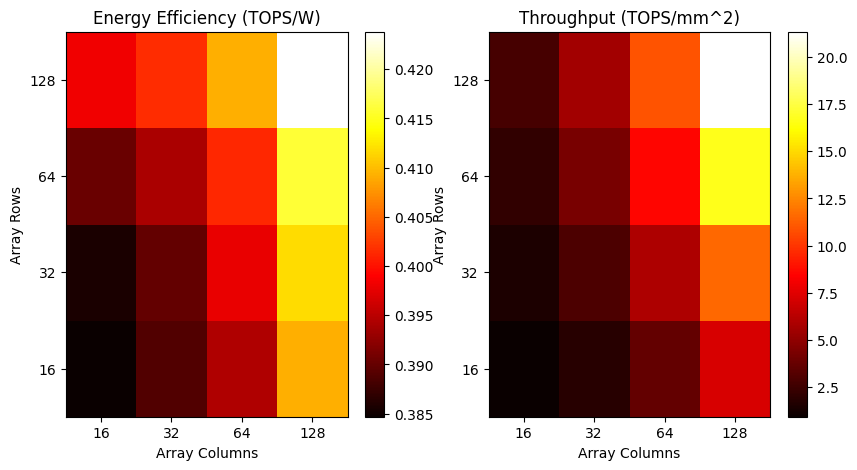

In [45]:
display_markdown(
    """
### Exploring Array Sizes

Here, we'll evaluate how the energy efficiency and throughput of the macro change
with different array sizes. We'll run the macro while setting the number of rows
and columns to 16, 32, 64, and 128. We'll then plot the throughput and energy
efficiency.
"""
)

import joblib
import matplotlib.pyplot as plt
import numpy as np

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# all_results = []
# for array_rows in [16, 32, 64, 128]:
#     for array_columns in [16, 32, 64, 128]:
#       all_results.append(run_basic_analog_spec(array_rows, array_columns))

all_results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_basic_analog_spec)(array_rows, array_columns)
    for array_rows in [16, 32, 64, 128]
    for array_columns in [16, 32, 64, 128]
)


# Extract energy efficiency and throughput from results
energy_efficiency = [r.tops_per_w for r in all_results]
throughput = [r.tops_per_mm2 for r in all_results]

# Reshape the data into a 2D grid
energy_efficiency_grid = np.array(energy_efficiency).reshape((4, 4))
throughput_grid = np.array(throughput).reshape((4, 4))

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)

for subplot, target, title in [
    (0, energy_efficiency_grid, "Energy Efficiency (TOPS/W)"),
    (1, throughput_grid, "Throughput (TOPS/mm^2)"),
]:
    im1 = ax[subplot].imshow(target, cmap="hot", aspect="auto")
    ax[subplot].set_title(title)
    ax[subplot].set_xlabel("Array Columns")
    ax[subplot].set_ylabel("Array Rows")
    ax[subplot].set_xticks(np.arange(4))
    ax[subplot].set_yticks(np.arange(4))
    ax[subplot].set_xticklabels([16, 32, 64, 128])
    ax[subplot].set_yticklabels([16, 32, 64, 128])
    ax[subplot].set_ylim(ax[subplot].get_ylim()[::-1])
    cbar = ax[subplot].figure.colorbar(im1, ax=ax[subplot])

display_markdown(
    """
Looking at these plots, we can see that the energy efficiency and throughput are
both influenced by the size of the CiM array. In fact, it appears that, as the
number of rows increases, the energy efficiency and throughput both increase. The
number of columns weakly effects the energy efficiency and throughput.
"""
)


To find out why the number of rows and columns influence energy efficiency,
we'll plot the energy breakdown of the CiM array as we vary the number of rows,
the number of columns, and then both at the same time.



We can see the following:

1. In all tests, the `cim_unit`s consume and the `row_drivers` consume little
   overall energy, while the `adc` dominates overall energy.
2. As the number of rows increases, `adc` energy per MAC decreases.
3. As the number of columns increases, `row_drivers` energy per MAC decreases.

These observations show the hints at one of the key design considerations in CiM
macros: how to reduce the area and energy cost of column readout circuitry, in
particular the ADCs. As we can see here, using more rows in the CiM array can
help reduce the energy cost of column readout circuits. This is just one of many
possible ways to reduce column readout energy. We'll explore other possibilities
later on.

Of course, this is just one macro; many other macros pay more energy for
`cim_unit` and `row_drivers` than for `adc`. There is a rich design
space to explore!

Before moving on, it may be helpful to stop for a moment and consider the
following questions:

1. Why does `adc` energy per compute decrease as the number of rows
   increase, but not the number of columns? And vice versa, why does
   `row_drivers` energy per compute decrease as the number of columns
   decreases, but not the number of rows?
2. Could there be other ways to decrease ADC, DAC, and row/column driver energy?



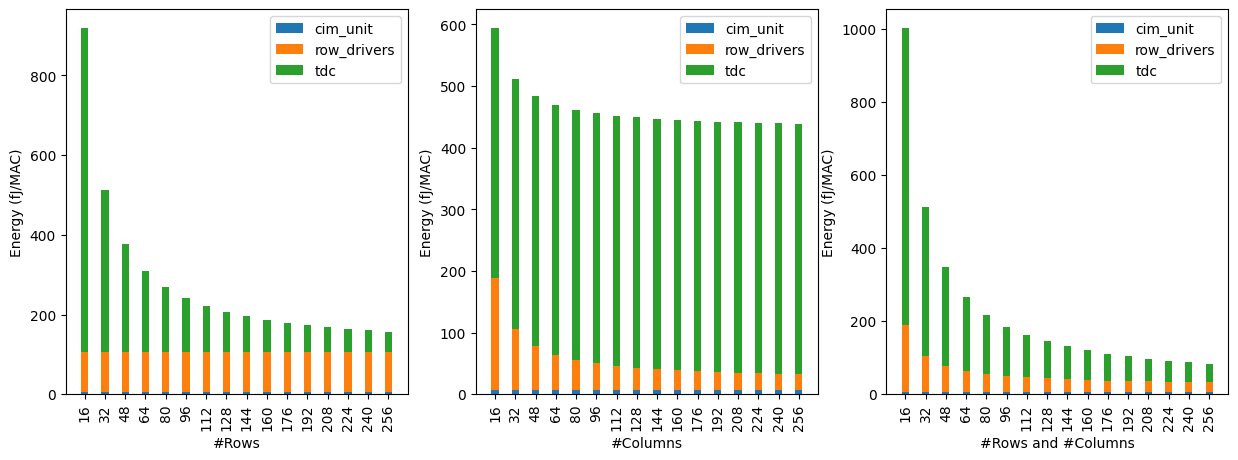

In [7]:
display_markdown(
    """
To find out why the number of rows and columns influence energy efficiency,
we'll plot the energy breakdown of the CiM array as we vary the number of rows,
the number of columns, and then both at the same time.
"""
)

array_sizes = list(range(16, 257, 16))
pJ_per_compute_adc = []
pJ_per_compute_row_drivers = []
pJ_per_compute_cim_unit = []

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# results = []
# for array_size in array_sizes:
#     results.append(run_basic_analog_spec(...))

results_vary_rows = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_basic_analog_spec)(array_rows=array_size, array_columns=32)
    for array_size in array_sizes
)
results_vary_columns = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_basic_analog_spec)(array_rows=32, array_columns=array_size)
    for array_size in array_sizes
)
results_vary_both = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_basic_analog_spec)(
        array_rows=array_size, array_columns=array_size
    )
    for array_size in array_sizes
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for subplot, target, xlabel in [
    (0, results_vary_rows, "#Rows"),
    (1, results_vary_columns, "#Columns"),
    (2, results_vary_both, "#Rows and #Columns"),
]:
    for r in target:
        r.clear_zero_energies()
    bar_stacked(
        {a: r.per_compute("per_component_energy")*1e15 for a, r in zip(array_sizes, target)},
        title="",
        xlabel=xlabel,
        ylabel="Energy (fJ/MAC)",
        ax=ax[subplot],
    )

display_markdown(
    """
We can see the following:

1. In all tests, the `cim_unit`s consume and the `row_drivers` consume little
   overall energy, while the `adc` dominates overall energy.
2. As the number of rows increases, `adc` energy per MAC decreases.
3. As the number of columns increases, `row_drivers` energy per MAC decreases.

These observations show the hints at one of the key design considerations in CiM
macros: how to reduce the area and energy cost of column readout circuitry, in
particular the ADCs. As we can see here, using more rows in the CiM array can
help reduce the energy cost of column readout circuits. This is just one of many
possible ways to reduce column readout energy. We'll explore other possibilities
later on.

Of course, this is just one macro; many other macros pay more energy for
`cim_unit` and `row_drivers` than for `adc`. There is a rich design
space to explore!

Before moving on, it may be helpful to stop for a moment and consider the
following questions:

1. Why does `adc` energy per compute decrease as the number of rows
   increase, but not the number of columns? And vice versa, why does
   `row_drivers` energy per compute decrease as the number of columns
   decreases, but not the number of rows?
2. Could there be other ways to decrease ADC, DAC, and row/column driver energy?

"""
)


### Full-DNN Explorations

Here, we'll evaluate the energy of each component in the macro when running a
the DNN ResNet18. We'll report how the energy varies for each layer.

We'll use a larger array here, 64 columns by 512 rows, to ensure that we can fit
all weights.


Available DNNs: ['alexnet', 'densenet201', 'dpt_large', 'gpt2_medium', 'mobilebert', 'mobilenet_v3', 'msft_phi_1_5', 'resnet18', 'vgg16', 'vision_transformer']
Running: 00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 


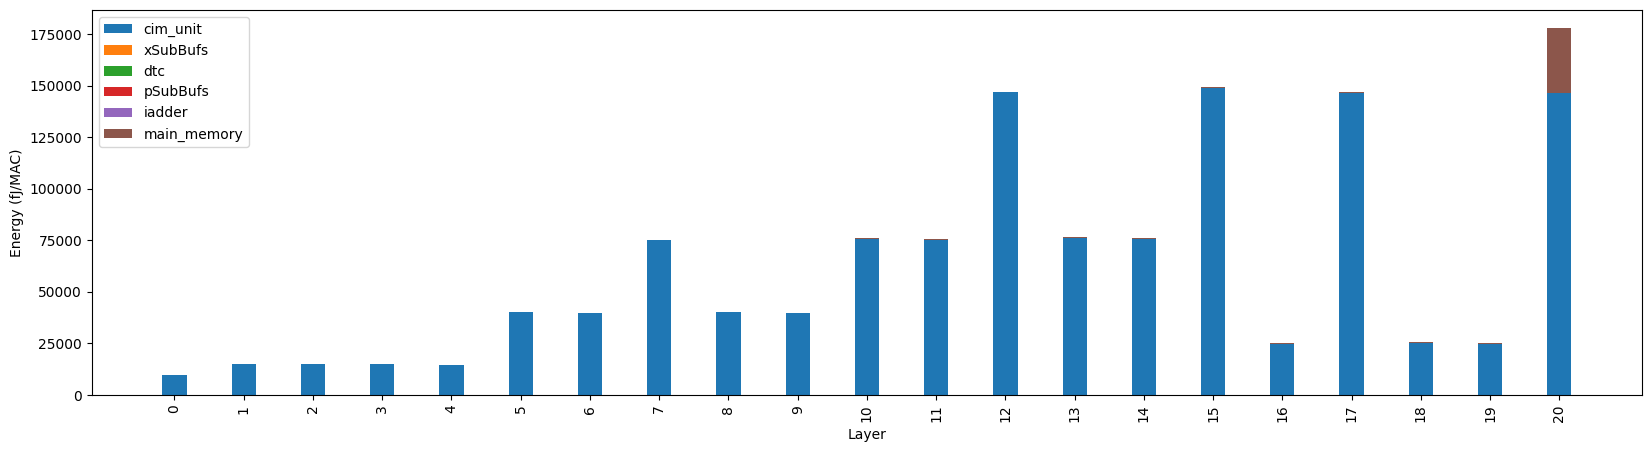

In [48]:
display_markdown(
    """
### Full-DNN Explorations

Here, we'll evaluate the energy of each component in the macro when running a
the DNN ResNet18. We'll report how the energy varies for each layer.

We'll use a larger array here, 64 columns by 512 rows, to ensure that we can fit
all weights.
"""
)


def run_layer(dnn: str, layer: str):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "timely",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="ws_dram_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    # Use a larger array to ensure we can fit all weights
    spec.architecture.find("column").spatial.meshX = 256
    spec.architecture.find("row").spatial.meshY = 256
    return run_mapper(spec)


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../models/workloads/")
    if os.path.isdir(f"../models/workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "resnet18"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers = [f for f in os.listdir(f"../models/workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers = sorted(layers)
print(f"Running: ", end="")

# Parallel/Delayed is used to multiprocess. Equivalent to running the following
# code in serial:
# results = [run_layer(DNN, layer.split(".")[0]) for layer in layers]
results = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0]) for layer in layers
)
print("")
for r in results:
    r.clear_zero_energies()

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results)},
    title="",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

In [11]:
display_markdown(
    """
Looking at the overall energy breakdown, we can see that the energy per MAC
varies greatly, with the `adc` consuming substantially more energy
for some layers rather than others. To see why, we can look at the loop nest
for some of the higher-energy layers.

The following code will find the highest-energy-per-MAC layer and print out the
loop nest.
"""
)
highest_energy_result = max(results, key=lambda x: x.per_compute("energy"))
print(f"Mapping:\n{highest_energy_result.mapping}")

display_markdown(
    """
Take a look at the nest below the `inter_row_spatial` heading, which shows how
the rows of the array are being utilized. Take the product of the loop bounds to
find the number of rows utilized. Are all 512 rows being utilized?

We know from the previous example that increasing the number of rows can
decrease `adc` energy per MAC. If the workload does not have
sufficient parallelism to utilize all rows, however, this benefit will not be
realized.
"""
)


Looking at the overall energy breakdown, we can see that the energy per MAC
varies greatly, with the `adc` consuming substantially more energy
for some layers rather than others. To see why, we can look at the loop nest
for some of the higher-energy layers.

The following code will find the highest-energy-per-MAC layer and print out the
loop nest.


Mapping:
dummy_top [ Inputs:401408 (401408) Outputs:802816 (802816) ] 
------------------------------------------------------------
| for P in [0:28)
|   for Q in [0:28)

inter_macro_in_system_spatial [ ] 
---------------------------------
|     for M in [0:2) (Spatial-X)

adc [ Outputs:512 (512) ] 
column_drivers [ Outputs:512 (512) ] 
row_drivers [ Inputs:512 (512) ] 
inter_column_spatial [ ] 
------------------------
|       for M in [0:64) (Spatial-X)

inter_row_spatial [ ] 
---------------------
|         for C in [0:64) (Spatial-Y)

cim_unit [ Weights:8 (8) ] 
inter_1bit_x_1bit_mac_spatial [ ] 
---------------------------------
|           for Z in [0:8) (Spatial-X)
|             for Y in [0:8) (Spatial-X)
|               for X in [0:8) (Spatial-X)

here_to_fix_a_bug [ ] 
---------------------
|                 << Compute >>




Take a look at the nest below the `inter_row_spatial` heading, which shows how
the rows of the array are being utilized. Take the product of the loop bounds to
find the number of rows utilized. Are all 512 rows being utilized?

We know from the previous example that increasing the number of rows can
decrease `adc` energy per MAC. If the workload does not have
sufficient parallelism to utilize all rows, however, this benefit will not be
realized.
